In [204]:
from __future__ import print_function  # Import the print function from future versions of Python
import argparse  # Library for parsing command-line arguments
import os  # Library for interacting with the operating system
import numpy as np  # Library for numerical operations
import torch.optim as optim  # Library for optimization algorithms in PyTorch
import matplotlib.pyplot as plt  # Library for plotting
import seaborn as sns  # Library for statistical visualization
from sklearn.metrics import confusion_matrix  # Function for computing confusion matrix
import torch.utils.data  # Utility functions for data loading in PyTorch
import torchvision.utils as vutils  # Utility functions for image-related operations
from torch.autograd import Variable  # Function for automatic differentiation
from functions import *  # Import custom functions from a separate module
from model import *  # Import custom model from a separate module

In [205]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='mnist', help='cifar10 | imagenet | mnist')
parser.add_argument('--dataroot', default='./datasets/', help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--imageSize', type=int, default=32, help='the height / width of the input image to network')
parser.add_argument('--nz', type=int, default=256, help='size of the latent z vector')
parser.add_argument('--niterC', type=int, default=20, help='number of epochs to train the classifier')
parser.add_argument('--nf', type=int, default=64, help='filters factor')
parser.add_argument('--drop', type=float, default=0.0, help='probably of drop out')
parser.add_argument('--lrC', type=float, default=0.2, help='learning rate of the classifier, default=0.0002')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--outf', default='output', help='folder to output images and model checkpoints')
parser.add_argument('--num_classes', type=int, default=10, help='Number of classes for AC-GAN')
parser.add_argument('--gpu_id', type=str, default='0', help='The ID of the specified GPU')

opt, unknown = parser.parse_known_args()
print(opt)

Namespace(dataset='mnist', dataroot='./datasets/', workers=2, batchSize=64, imageSize=32, nz=256, niterC=20, nf=64, drop=0.0, lrC=0.2, ngpu=1, outf='output', num_classes=10, gpu_id='0')


In [206]:
# Specify the GPU ID if using only 1 GPU
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpu_id

# Define the directory paths for saving files and checkpoints
dir_files = './results/'+opt.dataset+'/'+opt.outf
dir_checkpoint = './checkpoints/'+opt.dataset+'/'+opt.outf

# Create the directory for saving files if it doesn't exist
try:
    os.makedirs(dir_files)
except OSError:
    pass

# Create the directory for saving checkpoints if it doesn't exist
try:
    os.makedirs(dir_checkpoint)
except OSError:
    pass

# Set the device to use CUDA if available, otherwise use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set the number of training and testing samples based on the dataset
if opt.dataset == 'cifar10':
    n_train = 50000
    n_test = 10000
elif opt.dataset == 'svhn':
    n_train = 58606
    n_test = 14651
elif opt.dataset == 'mnist':
    n_train = 50000
    n_test = 10000
elif opt.dataset == 'fashion':
    n_train = 50000
    n_test = 10000

The code first sets the CUDA visible devices environment variable to the specified GPU ID. This is useful when you have multiple GPUs and want to select a specific one to use.

Next, the code defines two directory paths: **`dir_files`** and **`dir_checkpoint`**. These paths are used for saving files and checkpoints, respectively. The paths are constructed based on the provided dataset and output folder (**`opt.dataset`** and **`opt.outf`**).

The code then attempts to create the directories specified by the directory paths. If the directories already exist, the **`OSError`** exception is caught and ignored.

The **`device`** variable is set to use CUDA (GPU) if it is available, otherwise it falls back to using the CPU. This allows the code to leverage GPU acceleration if a compatible GPU is present.

Finally, the code sets the number of training and testing samples (**`n_train`** and **`n_test`**) based on the selected dataset. Each dataset has a predefined number of training and testing samples, and the code assigns the appropriate values based on the **`opt.dataset`** argument.

In summary, this section of the code handles GPU configuration, creates directories for saving files and checkpoints, determines the device (GPU or CPU) to use, and sets the number of training and testing samples based on the selected dataset.

In [207]:

# Get the train dataset
dataset, unorm, img_channels = get_dataset(dataset_name=opt.dataset, dataroot=opt.dataroot, imageSize=opt.imageSize, is_train=True, drop_rate=0.0)
# Create a train dataloader using the train dataset
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=n_train, shuffle=True, num_workers=int(opt.workers), drop_last=True)

# Get the test dataset
test_dataset, unorm, img_channels = get_dataset(dataset_name=opt.dataset, dataroot=opt.dataroot, imageSize=opt.imageSize, is_train=False, drop_rate=0.0)
# Create a test dataloader using the test dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=n_test, shuffle=False, num_workers=int(opt.workers), drop_last=True)


The code first calls the **`get_dataset`** function to obtain the train dataset. The function takes several arguments: **`dataset_name`** specifies the name of the dataset (e.g., "mnist", "cifar10"), **`dataroot`** specifies the path to the dataset, **`imageSize`** specifies the height and width of the input images to the network, **`is_train`** is set to **`True`** indicating that this is the train dataset, and **`drop_rate`** specifies the probability of dropout (set to 0.0 in this case). The function returns the train dataset, **`unorm`** (which is not used in this code), and **`img_channels`** (the number of channels in the input images).

Next, a train dataloader is created using the train dataset. The **`torch.utils.data.DataLoader`** class is used to load the data in batches. The **`dataset`** argument is the train dataset obtained from the previous step. The **`batch_size`** is set to **`n_train`**, which represents the number of training samples. The **`shuffle`** parameter is set to **`True`**, which randomly shuffles the training samples before each epoch. The **`num_workers`** parameter specifies the number of subprocesses to use for data loading. Finally, the **`drop_last`** parameter is set to **`True`**, which drops the last incomplete batch if the dataset size is not divisible by the batch size.

The code then follows a similar pattern to obtain the test dataset. The **`get_dataset`** function is called again, but this time **`is_train`** is set to **`False`** to indicate that this is the test dataset. The test dataset, **`test_dataset`**, is then used to create a test dataloader using similar arguments as the train dataloader.

In summary, this section of the code retrieves the train and test datasets using the **`get_dataset`** function and creates dataloaders to efficiently load the data in batches for training and testing purposes. The dataloaders are configured with batch size, shuffling, and other parameters to facilitate efficient and effective training and evaluation of the model.

In [208]:
# some hyper parameters
ngpu = int(opt.ngpu)
nz = int(opt.nz)
num_classes = int(opt.num_classes)
batch_size = opt.batchSize

# initiate networks
netG = Generator(ngpu, latent_dim=nz, ngf=opt.nf, img_channels=img_channels)
netG.apply(initialize_weights)
netD = Discriminator(ngpu, latent_dim=nz, ndf=opt.nf, img_channels=img_channels)
netD.apply(initialize_weights)
# send to GPU
netD.to(device)
netG.to(device)

Generator(
  (tconv1): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (tconv4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)

In [209]:
if os.path.exists(dir_checkpoint+'/trained.pth'):
    # Load data from last checkpoint
    print('Loading pre-trained model...')
    checkpoint = torch.load(dir_checkpoint+'/trained.pth', map_location='cpu')
    netG.load_state_dict(checkpoint['generator'])
    netD.load_state_dict(checkpoint['discriminator'])
    d_losses = checkpoint.get('d_losses', [float('inf')])
    g_losses = checkpoint.get('g_losses', [float('inf')])
    r_losses = checkpoint.get('r_losses', [float('inf')])
    print('Use loaded model...')
else:
    print('No pre-trained model detected, use randomly initialized network...')

Loading pre-trained model...
Use loaded model...


In [210]:
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

# Check if accuracies file exists
if os.path.exists(dir_files+'/accuracies.pth'):
    # Load data from last checkpoint
    print('Loading accuracies...')
    checkpoint = torch.load(dir_files+'/accuracies.pth', map_location='cpu')
    # Retrieve train accuracies from the checkpoint, or assign a default value if not found
    train_accuracies = checkpoint.get('train_accuracies', [float('inf')])
    # Retrieve test accuracies from the checkpoint, or assign a default value if not found
    test_accuracies = checkpoint.get('test_accuracies', [float('inf')])
    # Retrieve train losses from the checkpoint, or assign a default value if not found
    train_losses = checkpoint.get('train_losses', [float('inf')])
    # Retrieve test losses from the checkpoint, or assign a default value if not found
    test_losses = checkpoint.get('test_losses', [float('inf')])
else:
    print('No accuracies found...')


Loading accuracies...


The code initializes four empty lists: **`train_accuracies`**, **`test_accuracies`**, **`train_losses`**, and **`test_losses`**. These lists will be used to store the accuracy and loss values during training and testing.

The code then checks if a file named "accuracies.pth" exists in the specified directory (**`dir_files+'/accuracies.pth'`**). This file is expected to contain previously saved accuracy and loss values from a previous checkpoint.

If the file exists, the code proceeds to load the data from the last checkpoint. It prints a message indicating that the accuracies are being loaded.

The **`torch.load()`** function is used to load the checkpoint data from the file. The **`map_location`** parameter is set to **`'cpu'`** to ensure compatibility in case the checkpoint was saved on a different device. The loaded checkpoint is stored in the **`checkpoint`** variable.

The code then retrieves the train accuracies, test accuracies, train losses, and test losses from the loaded checkpoint using the **`get()`** method. If any of these values are not found in the checkpoint, a default value of **`[float('inf')]`** is assigned to the corresponding list. This default value of positive infinity (**`inf`**) serves as a placeholder to indicate that the data was not found.

If the accuracies file does not exist, the code simply prints a message indicating that no accuracies were found.

In summary, this section of the code initializes empty lists for storing accuracy and loss values. It checks if a file containing previously saved accuracies exists, and if so, loads the data from the last checkpoint. If the file does not exist, it prints a message indicating that no accuracies were found.

In [211]:
# project all train images on latent space
print("Storing training representations ...")

# Get a batch of images and labels from the training dataloader
image, label = next(iter(train_dataloader))
image, label = image.to(device), label.to(device)

# Set the discriminator network to evaluation mode
netD.eval()

# Disable gradient computation since we are only interested in the latent representations
with torch.no_grad():
    # Pass the images through the discriminator network to obtain the latent representations
    latent_output, _ = netD(image)
    # Move the latent representations and labels to the CPU
    train_features = latent_output.cpu()
    train_labels = label.cpu().long()


Storing training representations ...


The code aims to project all the training images onto the latent space using a pre-trained discriminator network (**`netD`**).

The code starts by printing a message indicating that the training representations are being stored.

Next, it retrieves a batch of images and labels from the training dataloader using the **`next()`** function. These images and labels are then moved to the device (GPU or CPU) specified earlier.

The discriminator network (**`netD`**) is set to evaluation mode using the **`.eval()`** method. This is done to ensure that any batch normalization or dropout layers in the network are in evaluation mode and do not update their parameters.

Gradient computation is disabled for efficiency since we are only interested in the latent representations, not in training the network. This is done using the **`torch.no_grad()`** context manager.

Within the **`torch.no_grad()`** context, the images are passed through the discriminator network (**`netD`**). The **`latent_output`** variable contains the output of the discriminator, which consists of the latent representations and the discriminator's prediction. Since we are only interested in the latent representations, we unpack and store them in the **`train_features`** variable.

The labels are also moved to the CPU and stored in the **`train_labels`** variable. They are converted to the **`long`** data type, which is commonly used for representing integer labels.

In summary, this section of the code retrieves a batch of training images and labels. It passes the images through the discriminator network to obtain the corresponding latent representations. These latent representations and the labels are then stored for further use in the training process.

In [212]:
# project all test images on latent space
print("Storing validation representations ...")

# Get a batch of images and labels from the test dataloader
image, label = next(iter(test_dataloader))
image, label = image.to(device), label.to(device)

# Set the discriminator network to evaluation mode
netD.eval()

# Disable gradient computation since we are only interested in the latent representations
with torch.no_grad():
    # Pass the images through the discriminator network to obtain the latent representations
    latent_output, _ = netD(image)
    # Move the latent representations and labels to the CPU
    test_features = latent_output.cpu()
    test_labels = label.cpu().long()


Storing validation representations ...


The code aims to project all the test images onto the latent space using a pre-trained discriminator network (**`netD`**).

The code starts by printing a message indicating that the validation representations are being stored.

Next, it retrieves a batch of images and labels from the test dataloader using the **`next()`** function. These images and labels are then moved to the device (GPU or CPU) specified earlier.

The discriminator network (**`netD`**) is set to evaluation mode using the **`.eval()`** method. This is done to ensure that any batch normalization or dropout layers in the network are in evaluation mode and do not update their parameters.

Gradient computation is disabled for efficiency since we are only interested in the latent representations, not in training the network. This is done using the **`torch.no_grad()`** context manager.

Within the **`torch.no_grad()`** context, the images are passed through the discriminator network (**`netD`**). The **`latent_output`** variable contains the output of the discriminator, which consists of the latent representations and the discriminator's prediction. Since we are only interested in the latent representations, we unpack and store them in the **`test_features`** variable.

The labels are also moved to the CPU and stored in the **`test_labels`** variable. They are converted to the **`long`** data type, which is commonly used for representing integer labels.

In summary, this section of the code retrieves a batch of test images and labels. It passes the images through the discriminator network to obtain the corresponding latent representations. These latent representations and the labels are then stored for further evaluation or analysis.

In [213]:
# create new datasets of latent vectors
linear_train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
linear_test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)

# create new dataloaders of latent vectors
linear_train_loader = torch.utils.data.DataLoader(linear_train_dataset, batch_size=batch_size, shuffle=True, num_workers=opt.workers, drop_last=True)
linear_test_loader = torch.utils.data.DataLoader(linear_test_dataset, batch_size=batch_size, shuffle=False, num_workers=opt.workers, drop_last=True)


The code creates new datasets and dataloaders for the latent vectors obtained from the previous step. These datasets and dataloaders will be used for training and testing a linear classifier.

First, a new dataset called **`linear_train_dataset`** is created using the **`torch.utils.data.TensorDataset`** class. It takes the **`train_features`** (latent vectors) and **`train_labels`** (corresponding labels) as inputs. Each sample in the dataset will consist of a latent vector and its associated label.

Similarly, a new dataset called **`linear_test_dataset`** is created using the same approach, but using the **`test_features`** and **`test_labels`**.

Next, new dataloaders are created for the linear datasets. The **`linear_train_loader`** is created using the **`torch.utils.data.DataLoader`** class, which takes the **`linear_train_dataset`** as input. It specifies the batch size (**`batch_size`**), enables shuffling of the data during training (**`shuffle=True`**), and sets the number of workers for data loading (**`num_workers=opt.workers`**). The **`drop_last=True`** parameter ensures that any incomplete batches at the end of each epoch are dropped.

Similarly, the **`linear_test_loader`** is created using the **`torch.utils.data.DataLoader`** class, but with the **`linear_test_dataset`** as input. The **`shuffle`** parameter is set to **`False`** since shuffling is not necessary during testing.

In summary, this section of the code creates new datasets and dataloaders for the latent vectors obtained from the previous step. These datasets and dataloaders will be used for training and testing a linear classifier on the latent representations of the data.

In [214]:
# nb of epochs to train linear classifier
n_epochs_c = opt.niterC
# loss function for linear classifier
class_criterion = nn.CrossEntropyLoss()

The code sets the number of epochs to train the linear classifier (**`n_epochs_c`**) and defines the loss function (**`class_criterion`**) to be used for training the classifier.

The variable **`n_epochs_c`** is assigned the value of **`opt.niterC`**, which is the number of epochs specified in the command-line arguments (**`--niterC`**). It determines how many times the linear classifier will iterate over the training data during training.

The **`class_criterion`** is initialized as an instance of the **`nn.CrossEntropyLoss()`** class. This loss function is commonly used for multi-class classification problems. It combines the softmax function and the negative log-likelihood loss to compute the loss between the predicted class probabilities and the true labels. It is suitable for training a linear classifier to classify the latent vectors into their respective classes.

In summary, this section of the code sets the number of epochs for training the linear classifier and initializes the loss function to be used during training.

In [ ]:
# Initialize lists for metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

# Initialize linear classifier
classifier = OutputClassifier(nz, num_classes=num_classes)
classifier.to(device)
optimizerC = optim.SGD(classifier.parameters(), lr=opt.lrC)

for epoch in range(n_epochs_c):
    store_train_acc = []
    store_test_acc = []
    store_train_loss = []
    store_test_loss = []

    print("Training on train set...")
    
    # Iterate over the training data
    for feature, label in linear_train_loader:
        feature, label = feature.to(device), label.to(device)
        classifier.train()
        optimizerC.zero_grad()
        # Forward pass through the linear classifier
        class_output = classifier(feature)
        # Compute the classification error
        class_err = class_criterion(class_output, label)
        # Backpropagation and update of the classifier's parameters
        class_err.backward()
        optimizerC.step()
        # Store train metrics
        train_acc = compute_acc(class_output, label)
        store_train_acc.append(train_acc)
        store_train_loss.append(class_err.item())

    print("Testing on test set...")
    # Compute test accuracy
    for feature, label in linear_test_loader:
        feature, label = feature.to(device), label.to(device)
        classifier.eval()
        # Forward pass through the linear classifier
        class_output = classifier(feature)
        class_err = class_criterion(class_output, label)
        # Store test metrics
        test_acc = compute_acc(class_output, label)
        store_test_acc.append(test_acc)
        store_test_loss.append(class_err.item())

    # Print and save metrics for the current epoch
    print('[%d/%d]  train_loss: %.4f  test_loss: %.4f  train_acc: %.4f  test_acc: %.4f'
          % (epoch, n_epochs_c, np.mean(store_train_loss), np.mean(store_test_loss),
             np.mean(store_train_acc), np.mean(store_test_acc)))
    
    # Save the trained classifier
    torch.save({'classifier': classifier.state_dict()}, dir_checkpoint + '/trained_classifier.pth')
    print(f'Classifier successfully saved.')

    # Append average metrics for the current epoch
    train_accuracies.append(np.mean(store_train_acc))
    train_losses.append(np.mean(store_train_loss))
    test_accuracies.append(np.mean(store_test_acc))
    test_losses.append(np.mean(store_test_loss))

# Save the accuracies
torch.save({
    'train_accuracies': train_accuracies,
    'test_accuracies': test_accuracies,
    'train_losses': train_losses,
    'test_losses': test_losses,
}, dir_files + '/accuracies.pth')
print(f'Accuracies successfully saved.')

# Plot losses and accuracies during training
epochs = np.arange(0, len(train_accuracies))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(epochs, train_losses, label='train loss')
ax1.plot(epochs, test_losses, label='test loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_title('Losses with Unsupervised Training')
ax1.legend()

ax2.plot(epochs, train_accuracies, label='train acc')
ax2.plot(epochs, test_accuracies, label='test acc')
ax2.set_ylim(0, 100)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy (%)')
ax2.set_title('Accuracy with Unsupervised Training')
ax2.legend()

fig.savefig(dir_files + '/linear_classif1.pdf')
plt.tight_layout()
plt.show()


This code trains a linear classifier using the latent vectors obtained from the unsupervised training. Here are the steps:

1. The lists **`train_accuracies`**, **`train_losses`**, **`test_accuracies`**, and **`test_losses`** are initialized to store the metrics during training.
2. An instance of the **`OutputClassifier`** class is created and moved to the appropriate device (CPU or GPU). The classifier is responsible for mapping the latent vectors to class labels.
3. The optimizer for the linear classifier is defined as stochastic gradient descent (SGD) with the learning rate specified in the command-line arguments (**`opt.lrC`**).
4. The training loop begins with iterating over the specified number of epochs (**`n_epochs_c`**).
5. For each epoch, temporary lists **`store_train_acc`**, **`store_test_acc`**, **`store_train_loss`**, and **`store_test_loss`** are initialized to store the metrics for each batch.
6. The training process starts by printing "Training on train set..." and iterating over the batches in the **`linear_train_loader`**.
7. Inside the loop, the feature vectors and labels are moved to the appropriate device. The classifier is set to the training mode (**`classifier.train()`**), the optimizer's gradients are zeroed (**`optimizerC.zero_grad()`**), and the feature vectors are passed through the classifier (**`class_output = classifier(feature)`**).
8. The classification error is computed using the specified loss function (**`class_criterion`**) by comparing the predicted class outputs with the true labels.
9. The backpropagation step is performed to compute the gradients and update the parameters of the classifier (**`class_err.backward()`** and **`optimizerC.step()`**).
10. The training accuracy is computed using the **`compute_acc()`** function, and the train metrics are appended to the temporary lists.
11. After the completion of the training loop, "Testing on test set..." is printed, and the testing process begins by iterating over the batches in the **`linear_test_loader`**.
12. Inside the testing loop, the feature vectors and labels are moved to the appropriate device. The classifier is set to the evaluation mode (**`classifier.eval()`**), and the feature vectors are passed through the classifier to obtain the class outputs.
13. The classification error and test accuracy are computed, and the metrics are stored in the respective temporary lists.
14. The average train and test metrics for the current epoch are printed.
15. The trained classifier is saved to a file.
16. The average metrics for the current epoch are appended to the respective lists for later analysis.
17. After the completion of all epochs, the train and test accuracies, as well as the train and test losses, are saved to a file.
18. The losses and accuracies are plotted over the epochs using **`matplotlib`**. Two subplots are created for loss and accuracy, and the plots are saved as a PDF file.
19. Finally, the plots are displayed on the screen.

In summary, this code trains a linear classifier using the latent vectors obtained from unsupervised training. It performs forward and backward passes through the classifier, updates its parameters using gradient descent, and computes and stores the training and testing metrics. The classifier's performance is evaluated and saved at each epoch, and the overall metrics are saved and plotted for analysis.

In [216]:
# Evaluate linear classifier on test set
predictions = []
true_labels = []
for feature, label in linear_test_loader:
    feature = feature.to(device)
    classifier.eval()
    class_output = classifier(feature)
    _, predicted_labels = torch.max(class_output, 1)
    predictions.extend(predicted_labels.cpu().numpy())
    true_labels.extend(label.cpu().numpy())

In [217]:
 cm = confusion_matrix(true_labels, predictions)

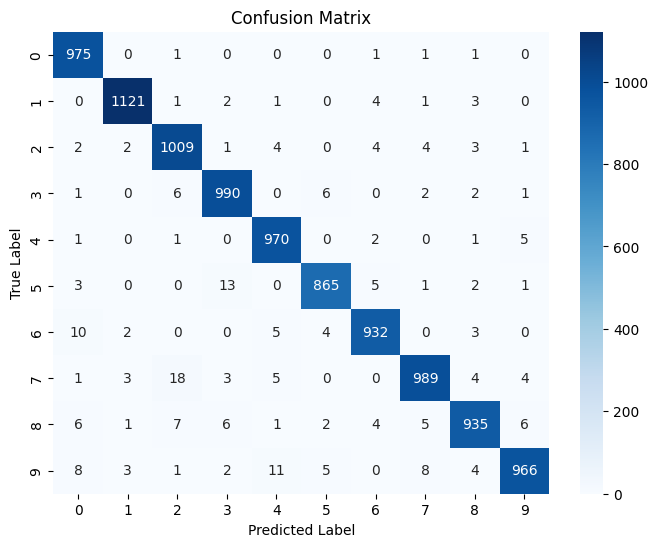

In [218]:
class_names = [str(i) for i in range(num_classes)]  # Replace with actual class names if available
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()